In [ ]:
#Dawn Schmidt
#Assignment 1
#Machine Learning 2
#June 15, 2024

Number of records for each occupation before encoding:
 Occupation
Nurse                   73
Doctor                  71
Engineer                63
Lawyer                  47
Teacher                 40
Accountant              37
Salesperson             32
Software Engineer        4
Scientist                4
Sales Representative     2
Manager                  1
Name: count, dtype: int64
Number of records for each occupation after encoding:
 Occupation_Accountant              37
Occupation_Doctor                  71
Occupation_Engineer                63
Occupation_Lawyer                  47
Occupation_Manager                  1
Occupation_Nurse                   73
Occupation_Sales Representative     2
Occupation_Salesperson             32
Occupation_Scientist                4
Occupation_Software Engineer        4
Occupation_Teacher                 40
dtype: int64


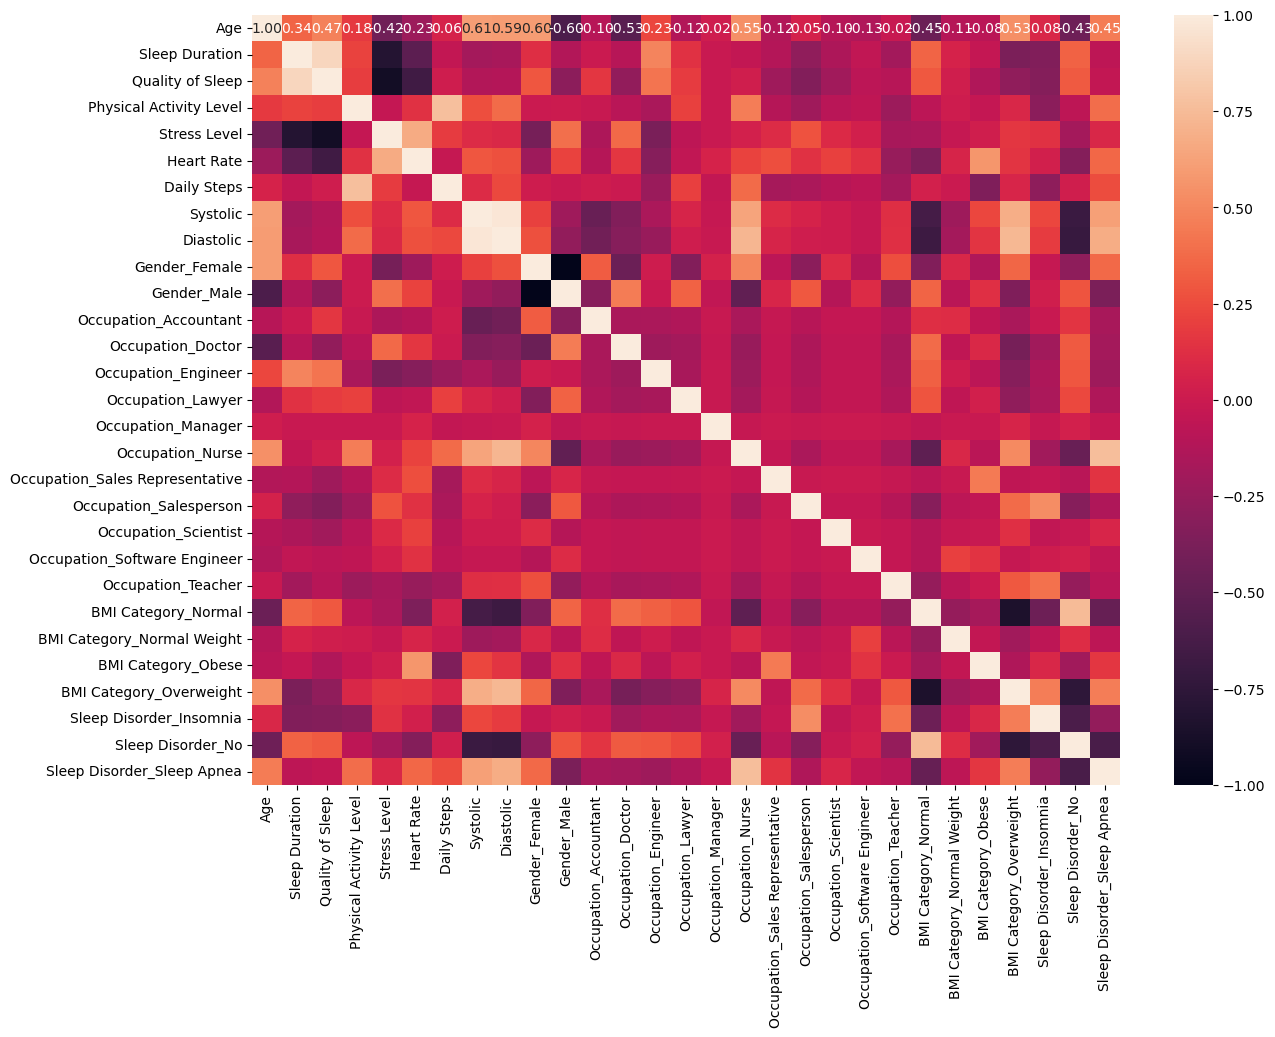

Correlation with 'Quality of Sleep':
 Quality of Sleep                   1.000000
Stress Level                       0.898752
Sleep Duration                     0.883213
Heart Rate                         0.659865
Age                                0.473734
Occupation_Engineer                0.414126
Occupation_Salesperson             0.335950
Sleep Disorder_Insomnia            0.332406
Sleep Disorder_No                  0.310984
BMI Category_Normal                0.304475
Gender_Male                        0.291366
Gender_Female                      0.291366
BMI Category_Overweight            0.280398
Occupation_Doctor                  0.269276
Occupation_Sales Representative    0.203211
Occupation_Scientist               0.201176
Physical Activity Level            0.192896
Occupation_Lawyer                  0.184201
Occupation_Accountant              0.160513
BMI Category_Obese                 0.126574
Systolic                           0.121632
Diastolic                          0.1

In [22]:
#import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

#load the dataset with person id as the index column
df = pd.read_csv('data_assignment1.csv', index_col=0)

#DATA PREP
#split 'blood pressure' into 'systolic' and 'diastolic'
df[['Systolic', 'Diastolic']] = df['Blood Pressure'].str.split('/', expand=True).astype(float)
df.drop(columns=['Blood Pressure'], inplace=True)

# Fill "none"'s in 'Sleep Disorder' with 'No'
df['Sleep Disorder'].fillna('No', inplace=True)

#verify the number of records for each occupation before encoding
print("Number of records for each occupation before encoding:\n", df['Occupation'].value_counts())

#one-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=['Gender', 'Occupation', 'BMI Category', 'Sleep Disorder'])

#verify the number of records for each occupation after encoding
occupation_columns = [col for col in df_encoded.columns if 'Occupation_' in col]
print("Number of records for each occupation after encoding:\n", df_encoded[occupation_columns].sum())

#check the correlation matrix
corr_matrix = df_encoded.corr()

#Q1
#plot the correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f')
plt.show()

#print correlation matrix for 'Quality of Sleep'
quality_corr = corr_matrix['Quality of Sleep'].abs().sort_values(ascending=False)
print("Correlation with 'Quality of Sleep':\n", quality_corr)

#filter numeric columns for correlation calculations
numeric_cols = df_encoded.select_dtypes(include=[np.number]).columns

#set a minimum threshold for the number of records required for correlation analysis
min_records_threshold = 5
print('')
print('')
print('TOP FEATURE BY OCCUPATION')
#calculate correlations for each occupation
for occupation in df['Occupation'].unique():
    df_occupation = df[df['Occupation'] == occupation][numeric_cols]
    
    if len(df_occupation) >= min_records_threshold:
        if df_occupation.nunique().min() > 1:
            corr_occupation = df_occupation.corr()['Quality of Sleep'].abs().sort_values(ascending=False)
            print('')
            print(f"Correlation with 'Quality of Sleep' for {occupation}:\n", corr_occupation)
            print('')
        else:
            print('')
            print(f"All values are identical for {occupation}, no meaningful correlation can be calculated.")
            print('')
    else:
        print('')
        print(f"Not enough data to calculate correlation for {occupation}")
        print('')
print('')
print('')
print('TOP FEATURE BY GENDER')
#calculate top feature by gender
for gender in df['Gender'].unique():
    df_gender = df[df['Gender'] == gender][numeric_cols]
    
    if len(df_gender) >= min_records_threshold:
        if df_gender.nunique().min() > 1:
            corr_gender = df_gender.corr()['Quality of Sleep'].abs().sort_values(ascending=False)
            print(f"Correlation with 'Quality of Sleep' for {gender}:\n", corr_gender)
            print('')
        else:
            print(f"All values are identical for {gender}, no meaningful correlation can be calculated.")
    else:
        print(f"Not enough data to calculate correlation for {gender}")


In [8]:
#Q2 - Which SVM kernel is best suited to predict stress level using the rest of the columns as features

#drop stress level from X and save Y as stress level column
X = df.drop(columns=['Stress Level'])
y = df['Stress Level']

#identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

#preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

#define the kernels to evaluate
kernels = ['rbf', 'sigmoid', 'linear', 'poly']

#number of folds for cross-validation
n_folds = 5

#evaluate SVM using cross-validation and accuracy
def evaluate_svm_cv(kernel, X, y, n_folds):
    svm = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', SVC(kernel=kernel, gamma='scale'))])
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=1)
    scores = cross_val_score(svm, X, y, cv=kf, scoring='accuracy')
    return scores.mean()

#evaluate the kernels and generate accuracy score
results = {kernel: evaluate_svm_cv(kernel, X, y, n_folds) for kernel in kernels}

print("Cross Validation Accuracy results for model using all predictors:")
for kernel, score in results.items():
    print(f"Cross-Validation Accuracy for {kernel} kernel: {score}")

Cross Validation Accuracy results for model using all predictors:
Cross-Validation Accuracy for rbf kernel: 0.9545225225225226
Cross-Validation Accuracy for sigmoid kernel: 0.8796756756756757
Cross-Validation Accuracy for linear kernel: 0.9651531531531532
Cross-Validation Accuracy for poly kernel: 0.9438198198198199


In [10]:
#Q2 - determine which SVM Kernel is best to predict stress level using Age and Sleep as predictors


#save subset of df with quality of sleep and age
#save subset of df with stress level to use as target variable
X_subset = df[['Quality of Sleep', 'Age']]
y = df['Stress Level']

#standardize the features in subset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_subset)

#function to evaluate SVM using cross-validation
def evaluate_svm_cv(kernel, X_scaled, y, n_folds):
    svm = SVC(kernel=kernel, gamma='scale')
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=1)
    scores = cross_val_score(svm, X_scaled, y, cv=kf, scoring='accuracy')
    return scores.mean()

#evaluate the kernels
results = {}

for kernel in kernels:
    score = evaluate_svm_cv(kernel, X_scaled, y, n_folds)
    results[kernel] = score

#print cross-validation accuracy
for kernel, score in results.items():
    print(f"Cross-Validation Accuracy for {kernel} kernel: {score}")

Cross-Validation Accuracy for rbf kernel: 0.8555675675675676
Cross-Validation Accuracy for sigmoid kernel: 0.6256936936936937
Cross-Validation Accuracy for linear kernel: 0.7513513513513514
Cross-Validation Accuracy for poly kernel: 0.7834594594594595


Silhouette Score for RBF kernel: 0.1626577554219855
Silhouette Score for Sigmoid kernel: 0.2280581304090543
Silhouette Score for Linear kernel: 0.1074923532188141
Silhouette Score for Poly kernel: -0.08583528639333433


C:\Users\dasch\AppData\Local\Temp\ipykernel_1760\1178268083.py:65: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  plt.legend([a.collections[0], b1, b2, c],


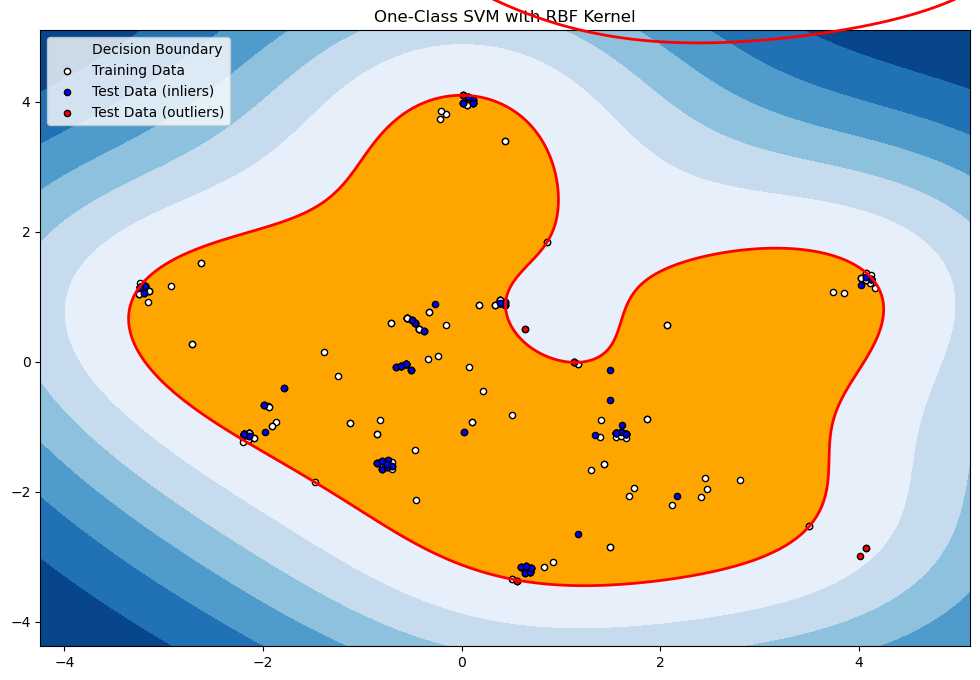

C:\Users\dasch\AppData\Local\Temp\ipykernel_1760\1178268083.py:65: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  plt.legend([a.collections[0], b1, b2, c],


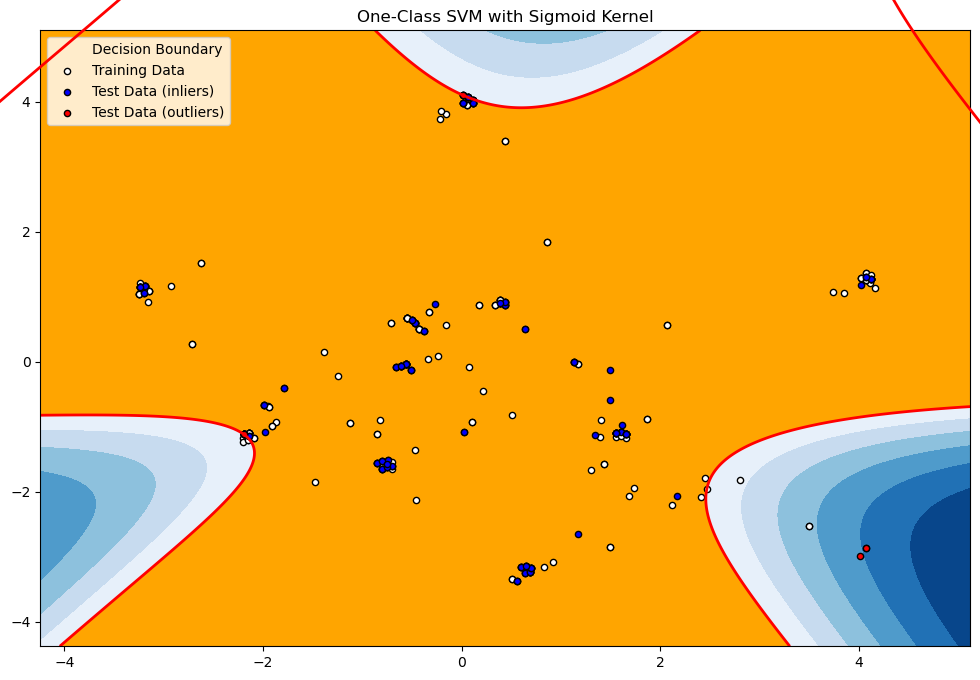

C:\Users\dasch\AppData\Local\Temp\ipykernel_1760\1178268083.py:65: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  plt.legend([a.collections[0], b1, b2, c],


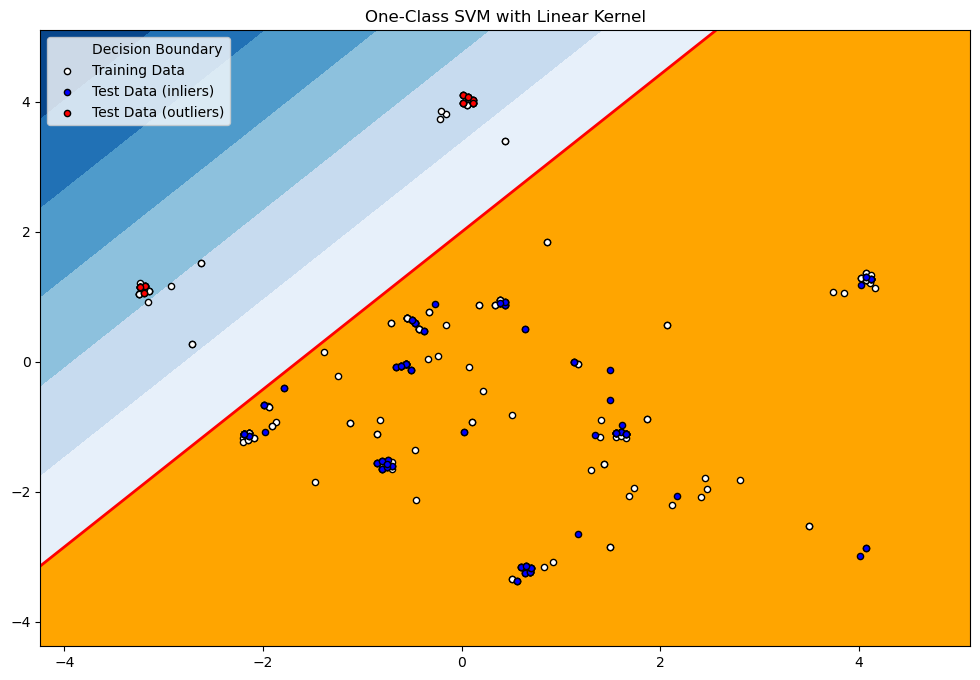

C:\Users\dasch\AppData\Local\Temp\ipykernel_1760\1178268083.py:65: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  plt.legend([a.collections[0], b1, b2, c],


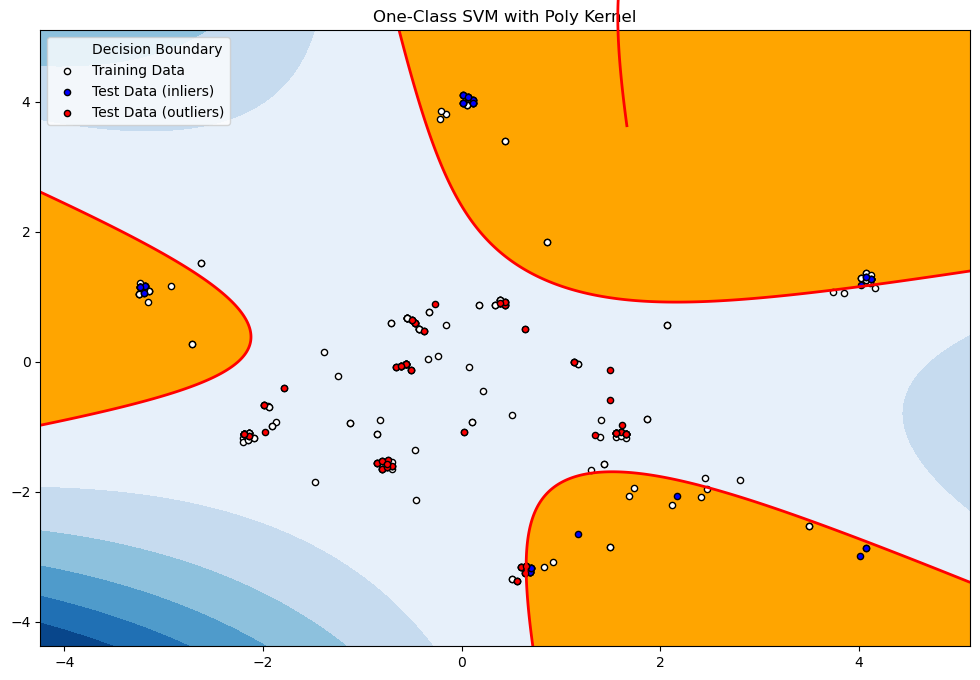

In [12]:
#first run of sillhouette scores before optimzation


#preprocessing pipeline
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(exclude=['object']).columns

#define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

#apply the preprocessing pipeline to the data
X = df
X_preprocessed = preprocessor.fit_transform(X)

#split the data into training and testing sets
X_train, X_test = train_test_split(X_preprocessed, test_size=0.2, random_state=42)

#function to fit and evaluate One-Class SVM
def fit_and_evaluate_ocsvm(kernel, X_train, X_test, kernel_name):
    ocsvm = OneClassSVM(kernel=kernel, gamma='scale', nu=0.05)
    ocsvm.fit(X_train)
    y_pred_test = ocsvm.predict(X_test)
    silhouette = silhouette_score(X_test, y_pred_test)
    print(f"Silhouette Score for {kernel_name} kernel: {silhouette}")
    return ocsvm, y_pred_test

#fit and evaluate models with each kernel
ocsvm_rbf, y_pred_test_rbf = fit_and_evaluate_ocsvm('rbf', X_train, X_test, 'RBF')
ocsvm_sigmoid, y_pred_test_sigmoid = fit_and_evaluate_ocsvm('sigmoid', X_train, X_test, 'Sigmoid')
ocsvm_linear, y_pred_test_linear = fit_and_evaluate_ocsvm('linear', X_train, X_test, 'Linear')
ocsvm_poly, y_pred_test_poly = fit_and_evaluate_ocsvm('poly', X_train, X_test, 'Poly')

#function for decision boundary visualization
def visualize_decision_boundary(ocsvm, X_train, X_test, title):
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    ocsvm.fit(X_train_pca)
    y_pred_test_pca = ocsvm.predict(X_test_pca)

    xx, yy = np.meshgrid(np.linspace(X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1, 500),
                         np.linspace(X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1, 500))

    Z = ocsvm.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(12, 8))
    plt.title(title)
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.Blues_r)
    a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='red')
    plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='orange')

    b1 = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c='white', s=20, edgecolor='k')
    b2 = plt.scatter(X_test_pca[y_pred_test_pca == 1, 0], X_test_pca[y_pred_test_pca == 1, 1], c='blue', s=20, edgecolor='k')
    c = plt.scatter(X_test_pca[y_pred_test_pca == -1, 0], X_test_pca[y_pred_test_pca == -1, 1], c='red', s=20, edgecolor='k')

    plt.axis('tight')
    plt.xlim((xx.min(), xx.max()))
    plt.ylim((yy.min(), yy.max()))
    plt.legend([a.collections[0], b1, b2, c],
               ["Decision Boundary", "Training Data",
                "Test Data (inliers)", "Test Data (outliers)"],
               loc="upper left")
    plt.show()

#model the decision boundaries for each kernel
visualize_decision_boundary(ocsvm_rbf, X_train, X_test, "One-Class SVM with RBF Kernel")
visualize_decision_boundary(ocsvm_sigmoid, X_train, X_test, "One-Class SVM with Sigmoid Kernel")
visualize_decision_boundary(ocsvm_linear, X_train, X_test, "One-Class SVM with Linear Kernel")
visualize_decision_boundary(ocsvm_poly, X_train, X_test, "One-Class SVM with Poly Kernel")


In [14]:
#use grid search to find the optimal parameters for sigmoid model

#define the parameter grid
param_grid = {
    'nu': [0.01, 0.05, 0.1, 0.2],
    'gamma': ['scale', 'auto']
}

#start One-Class SVM with sigmoid kernel
ocsvm = OneClassSVM(kernel='sigmoid')

#start the GridSearchCV object
grid_search = GridSearchCV(estimator=ocsvm, param_grid=param_grid, cv=5, scoring='accuracy')

#fit the model
grid_search.fit(X_train, np.ones(X_train.shape[0]))  #ones for unsupervised task

#get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score}")


Best Parameters: {'gamma': 'scale', 'nu': 0.01}
Best Cross-Validation Score: 0.9800000000000001


Optimized Silhouette Score for Sigmoid Kernel: 0.2655770887183932


C:\Users\dasch\AppData\Local\Temp\ipykernel_7504\976177556.py:76: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  plt.legend([a.collections[0], b1, b2, c],


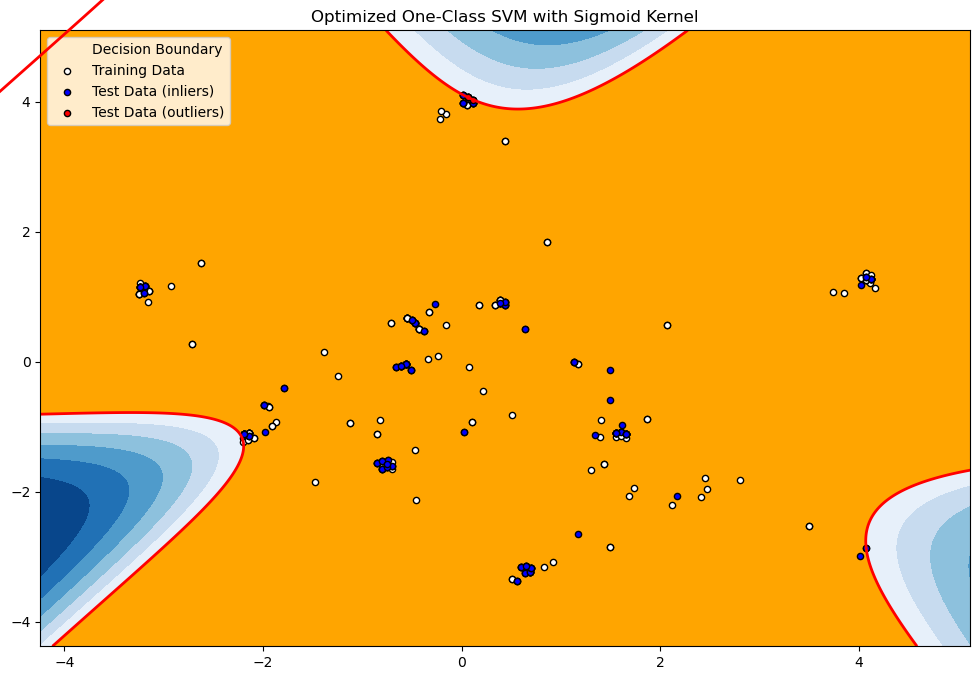

In [487]:
#run and plot the sigmoid model with optimized parameters
#fit the optimized sigmoid model on the training data
ocsvm_optimized = OneClassSVM(kernel='sigmoid', gamma='scale', nu=0.01)
ocsvm_optimized.fit(X_train)

#predict on the test data
y_pred_test_optimized = ocsvm_optimized.predict(X_test)

#calculate the silhouette score for the test data
silhouette_optimized = silhouette_score(X_test, y_pred_test_optimized)
print(f"Optimized Silhouette Score for Sigmoid Kernel: {silhouette_optimized}")

#model the decision boundary for the optimized model
visualize_decision_boundary(ocsvm_optimized, X_train, X_test, "Optimized One-Class SVM with Sigmoid Kernel")


In [674]:
#####Q3 - Outlier Detection - SIGMOID


#one-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=['Gender', 'Occupation', 'BMI Category', 'Sleep Disorder'])

#standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_encoded)

#fit the One-Class SVM model with RBF kernel
oc_svm_sigmoid = OneClassSVM(kernel='sigmoid', gamma='scale', nu=0.01)
oc_svm_sigmoid.fit(df_scaled)

#predict outliers
outlier_predictions_sigmoid = oc_svm_sigmoid.predict(df_scaled)

#get the indexes of the outliers
outlier_indexes_sigmoid = df.index[outlier_predictions_sigmoid == -1]

#count outliers for each gender and occupation
outliers_df_sigmoid = df.loc[outlier_indexes_sigmoid]
outlier_counts_gender_sigmoid = outliers_df_sigmoid['Gender'].value_counts()
outlier_counts_occupation_sigmoid = outliers_df_sigmoid['Occupation'].value_counts()

#print results
print("Indexes of outliers in the test set:", outlier_indexes_sigmoid)
print("\nCount of outliers by gender in the test set:\n", outlier_counts_gender_sigmoid)
print("\nCount of outliers by occupation in the test set:\n", outlier_counts_occupation_sigmoid)
silhouette_avg_sigmoid = silhouette_score(df_scaled, outlier_predictions_sigmoid)
print("Silhouette Score (Sigmoid Kernel):", silhouette_avg_sigmoid)

Indexes of outliers in the test set: Index([147, 204, 205, 360], dtype='int64', name='Person ID')

Count of outliers by gender in the test set:
 Gender
Male      3
Female    1
Name: count, dtype: int64

Count of outliers by occupation in the test set:
 Occupation
Engineer    2
Lawyer      1
Nurse       1
Name: count, dtype: int64
Silhouette Score (Sigmoid Kernel): -0.018676271410175697


Silhouette Score for Isolation Forest: 0.35448881577888497


C:\Users\dasch\AppData\Local\Temp\ipykernel_7504\1739793667.py:71: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  plt.legend([a.collections[0], b1, b2, c],


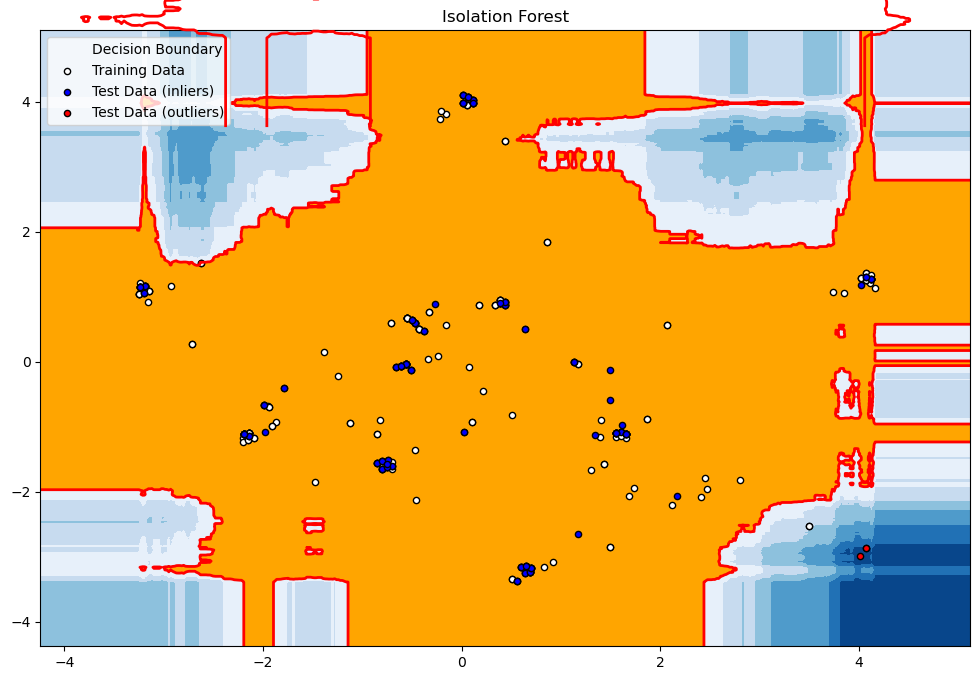

In [619]:
#generate additional model and using isolation forest TEST

#start and fit isolation forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
iso_forest.fit(X_train)

#predict on the test data
y_pred_iso_forest = iso_forest.predict(X_test)

#calculate the silhouette score for the test data
silhouette_iso_forest = silhouette_score(X_test, y_pred_iso_forest)
print(f"Silhouette Score for Isolation Forest: {silhouette_iso_forest}")

#generate decision boundary for isolation forest model
visualize_decision_boundary(iso_forest, X_train, X_test, "Isolation Forest")


In [537]:
#RBF outlier prediction TEST


#fit the SVM on the entire data
ocsvm_test = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01)
ocsvm_test.fit(X_preprocessed)

#predict on the entire dataset to identify outliers
y_pred_all = ocsvm_test.predict(X_preprocessed)

#identify outliers (where prediction is -1 (outliers))
outliers = df[y_pred_all == -1]

#total count by gender
outliers_by_gender = outliers['Gender'].value_counts()

#total count by occupation
outliers_by_occupation = outliers['Occupation'].value_counts()

#display results
print("Total count by gender:")
print(outliers_by_gender)

print("\nTotal count by occupation:")
print(outliers_by_occupation)

print("\nOutliers identified:")
print(outliers)

Total count by gender:
Gender
Male      9
Female    4
Name: count, dtype: int64

Total count by occupation:
Occupation
Doctor                  8
Sales Representative    2
Software Engineer       1
Nurse                   1
Engineer                1
Name: count, dtype: int64

Outliers identified:
           Gender  Age            Occupation  Sleep Duration  \
Person ID                                                      
2            Male   28                Doctor             6.2   
3            Male   28                Doctor             6.2   
4            Male   28  Sales Representative             5.9   
5            Male   28  Sales Representative             5.9   
6            Male   28     Software Engineer             5.9   
14           Male   29                Doctor             6.0   
15           Male   29                Doctor             6.0   
16           Male   29                Doctor             6.0   
18           Male   29                Doctor             6.0   

Silhouette Score for Sigmoid kernel: 0.2280581304090543


C:\Users\dasch\AppData\Local\Temp\ipykernel_7504\1348221186.py:76: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  plt.legend([a.collections[0], b1, b2, c, d],


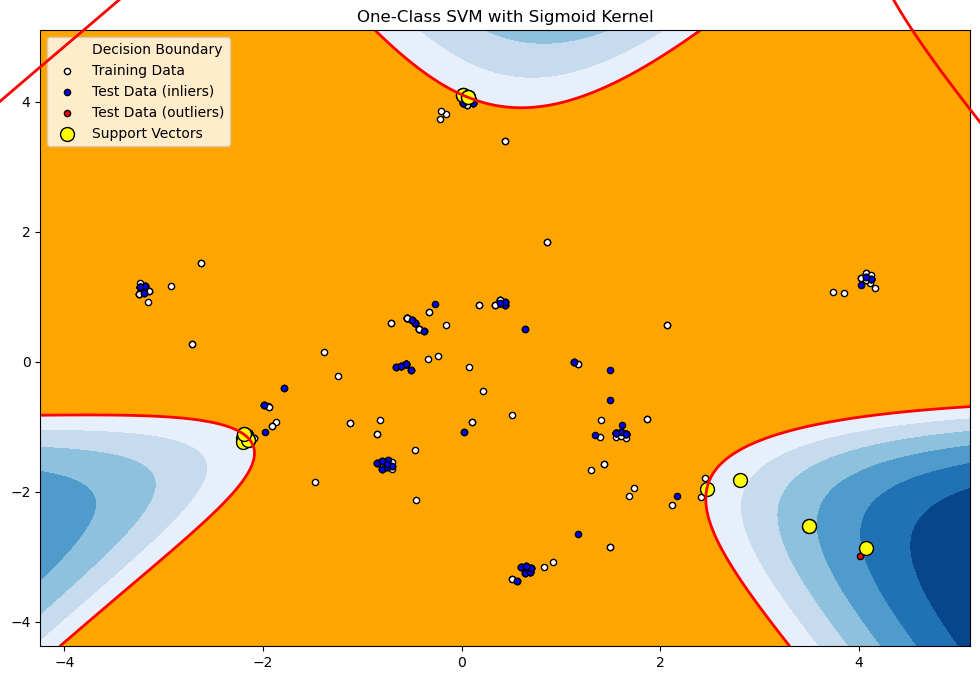

In [672]:
#test Q 4 - support vector on sigmoid model


#preprocessing pipeline
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(exclude=['object']).columns

#define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

#apply the preprocessing pipeline to the data
X = df
X_preprocessed = preprocessor.fit_transform(X)

#split the data into training and testing sets
X_train, X_test = train_test_split(X_preprocessed, test_size=0.2, random_state=42)

#function to fit and evaluate One-Class SVM
def fit_and_evaluate_ocsvm(kernel, X_train, X_test, kernel_name):
    ocsvm = OneClassSVM(kernel=kernel, gamma='scale', nu=0.05)
    ocsvm.fit(X_train)
    y_pred_test = ocsvm.predict(X_test)
    silhouette = silhouette_score(X_test, y_pred_test)
    print(f"Silhouette Score for {kernel_name} kernel: {silhouette}")
    return ocsvm, y_pred_test

#fit and evaluate model with sigmoid kernel
ocsvm_sigmoid, y_pred_test_sigmoid = fit_and_evaluate_ocsvm('sigmoid', X_train, X_test, 'Sigmoid')

#function for decision boundary visualization including support vectors
def visualize_decision_boundary_with_support_vectors(ocsvm, X_train, X_test, title):
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    #refit the one-class SVM model on the PCA-transformed training data
    ocsvm_pca = OneClassSVM(kernel='sigmoid', gamma='scale', nu=0.05)
    ocsvm_pca.fit(X_train_pca)
    y_pred_test_pca = ocsvm_pca.predict(X_test_pca)

    #get support vectors
    support_vectors_pca = ocsvm_pca.support_

    xx, yy = np.meshgrid(np.linspace(X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1, 500),
                         np.linspace(X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1, 500))

    Z = ocsvm_pca.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(12, 8))
    plt.title(title)
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.Blues_r)
    a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='red')
    plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='orange')

    b1 = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c='white', s=20, edgecolor='k', facecolors='none')
    b2 = plt.scatter(X_test_pca[y_pred_test_pca == 1, 0], X_test_pca[y_pred_test_pca == 1, 1], c='blue', s=20, edgecolor='k')
    c = plt.scatter(X_test_pca[y_pred_test_pca == -1, 0], X_test_pca[y_pred_test_pca == -1, 1], c='red', s=20, edgecolor='k')
    d = plt.scatter(X_train_pca[support_vectors_pca, 0], X_train_pca[support_vectors_pca, 1], c='yellow', s=100, edgecolors='k')

    plt.axis('tight')
    plt.xlim((xx.min(), xx.max()))
    plt.ylim((yy.min(), yy.max()))
    plt.legend([a.collections[0], b1, b2, c, d],
               ["Decision Boundary", "Training Data",
                "Test Data (inliers)", "Test Data (outliers)", "Support Vectors"],
               loc="upper left")
    plt.show()

#visualize the decision boundary with support vectors for the sigmoid kernel
visualize_decision_boundary_with_support_vectors(ocsvm_sigmoid, X_train, X_test, "One-Class SVM with Sigmoid Kernel")


C:\Users\dasch\AppData\Local\Temp\ipykernel_7504\4221848416.py:59: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  plt.legend([a.collections[0], b1, b2, c],


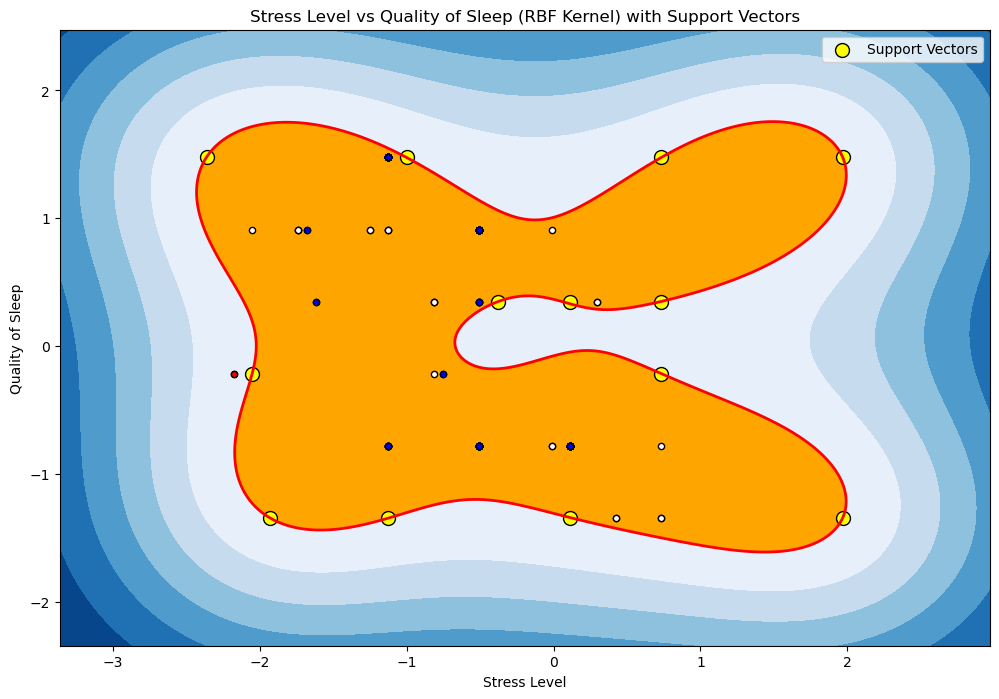

In [664]:
#Q4 support vectors

#apply the preprocessing pipeline to the data
X = df
X_preprocessed = preprocessor.fit_transform(X)

#extract original columns for stress level and quality of sleep
stress_index = df.columns.get_loc("Stress Level")
sleep_index = df.columns.get_loc("Quality of Sleep")

#extract the Stress Level and Quality of Sleep features
X_stress_sleep = X_preprocessed[:, [stress_index, sleep_index]]

#split the data into training and testing sets
X_train, X_test = train_test_split(X_stress_sleep, test_size=0.2, random_state=42)

#fit the One-Class SVM model on the stress and sleep data
ocsvm_rbf = OneClassSVM(kernel='rbf', gamma='scale', nu=0.01)
ocsvm_rbf.fit(X_train)
y_pred_test_rbf = ocsvm_rbf.predict(X_test)

#create plot
xx, yy = np.meshgrid(np.linspace(X_test[:, 0].min() - 1, X_test[:, 0].max() + 1, 500),
                     np.linspace(X_test[:, 1].min() - 1, X_test[:, 1].max() + 1, 500))

Z = ocsvm_rbf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(12, 8))
plt.title("Stress Level vs Quality of Sleep (RBF Kernel) with Support Vectors")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='orange')

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=20, edgecolor='k', facecolors='none')
b2 = plt.scatter(X_test[y_pred_test_rbf == 1, 0], X_test[y_pred_test_rbf == 1, 1], c='blue', s=20, edgecolor='k')
c = plt.scatter(X_test[y_pred_test_rbf == -1, 0], X_test[y_pred_test_rbf == -1, 1], c='red', s=20, edgecolor='k')

#highlight support vectors
sv = ocsvm_rbf.support_vectors_
plt.scatter(sv[:, 0], sv[:, 1], s=100, edgecolors='k', facecolors='yellow', marker='o', label='Support Vectors')

plt.axis('tight')
plt.xlim((xx.min(), xx.max()))
plt.ylim((yy.min(), yy.max()))
plt.xlabel("Stress Level")
plt.ylabel("Quality of Sleep")
plt.legend([a.collections[0], b1, b2, c],
           ["Decision Boundary", "Training Data",
            "Test Data (inliers)", "Test Data (outliers)"],
           loc="upper left")
plt.legend()
plt.show()
